In [ ]:
!pip install qiskit
!pip install qiskit_aer                   #simulacion de alto desempeño
!pip install "qiskit[visualization]"      #visualizacion de los circitos cuanticos
!pip install qiskit_machine_learning
!pip install qiskit_algorithms
!pip install -U qiskit qiskit-machine-learning qiskit-aer qiskit-algorithms



  Using cached qiskit-2.2.1-cp39-abi3-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (12 kB)


Cargando dataset...
Dataset original: (16599, 19)
Train: (210, 8), Test: (90, 8), Features: 8
Baseline RF MSE: 0.000058
Entrenando QSVR...
QSVR MSE: 0.000194, MAE: 0.012978, Tiempo: 285.0s


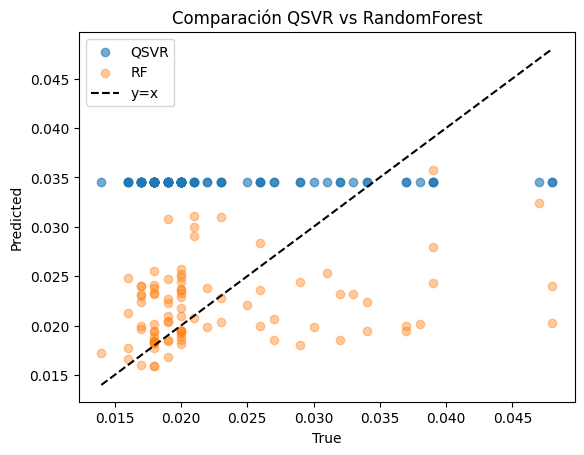

Modelo QSVR guardado en 'best_qsvr_model.pkl'


In [ ]:
# vqr_qsvr_pipeline.py
# Pipeline QSVR sobre dataset 'elevators.dat' con configuración ADAM_150

import pickle
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor

from qiskit import *
from qiskit.circuit.library import ZZFeatureMap, RealAmplitudes
from qiskit_algorithms.optimizers import ADAM
from qiskit_machine_learning.algorithms import QSVR
from qiskit_machine_learning.kernels import FidelityQuantumKernel

# =============================================
# ⚙️ Configuración
# =============================================
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

SAMPLE_SIZE = 300
LOF_N_NEIGHBORS = 10
LOF_CONTAMINATION = 0.05
FEATURES_CANDIDATES = ['SaTime1','SaTime2','SaTime3','Sa','SaTime4','AbsRoll','Q','ClimbRate']
TARGET_COL = 'Goal'
FEATURE_SCALE_RANGE = (-np.pi, np.pi)
TEST_SIZE = 0.3

# =============================================
# 1) Carga de datos
# =============================================
print("Cargando dataset...")
url = "https://raw.githubusercontent.com/Alisser2001/QuantumMachineLearning/emmadev/elevators.dat"
lines = [l.strip() for l in requests.get(url).text.splitlines()]
attributes = [line.split()[1] for line in lines if line.lower().startswith("@attribute")]
data_start = next(i for i,l in enumerate(lines) if l.lower() == "@data") + 1
rows = [ln for ln in lines[data_start:] if ln and not ln.startswith('%')]
data = [r.split(',') for r in rows]
df = pd.DataFrame(data, columns=attributes).apply(pd.to_numeric)
print(f"Dataset original: {df.shape}")

# =============================================
# 2) Filtrado de outliers con LOF
# =============================================
X_all = df[FEATURES_CANDIDATES]
y_all = df[TARGET_COL]

lof = LocalOutlierFactor(n_neighbors=LOF_N_NEIGHBORS, contamination=LOF_CONTAMINATION)
mask_inliers = lof.fit_predict(X_all) == 1
X_all, y_all = X_all[mask_inliers], y_all[mask_inliers]

# =============================================
# 3) Muestreo reducido
# =============================================
idx = np.random.choice(len(X_all), min(SAMPLE_SIZE, len(X_all)), replace=False)
X_all = X_all.iloc[idx].reset_index(drop=True)
y_all = y_all.iloc[idx].reset_index(drop=True)

# =============================================
# 4) Transformación log + escalado
# =============================================
for c in ['SaTime1','SaTime2','SaTime3','Sa','SaTime4']:
    if c in X_all.columns:
        X_all[c] = np.log1p(np.clip(X_all[c].values, a_min=0, a_max=None))

scaler = MinMaxScaler(feature_range=FEATURE_SCALE_RANGE)
X_scaled = scaler.fit_transform(X_all)

# =============================================
# 5) División train/test
# =============================================
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_all, test_size=TEST_SIZE, random_state=RANDOM_STATE)
num_features = X_train.shape[1]
print(f"Train: {X_train.shape}, Test: {X_test.shape}, Features: {num_features}")

# =============================================
# 6) Baseline clásico
# =============================================
rf = RandomForestRegressor(n_estimators=100, random_state=RANDOM_STATE)
rf.fit(X_train, y_train)
pred_rf = rf.predict(X_test)
rf_mse = mean_squared_error(y_test, pred_rf)
print(f"Baseline RF MSE: {rf_mse:.6f}")

# =============================================
# 7) Configuración QSVR con ZZFeatureMap_r2 y RealAmplitudes_r2
# =============================================
fmap = ZZFeatureMap(feature_dimension=num_features, reps=2, entanglement="linear")
ansatz = RealAmplitudes(num_qubits=num_features, reps=2, entanglement="linear")
optimizer = ADAM(maxiter=150)

qkernel = FidelityQuantumKernel(feature_map=fmap)
qsvr = QSVR(quantum_kernel=qkernel, C=2.0)  # C ajustable si quieres

# =============================================
# 8) Entrenamiento QSVR
# =============================================
print("Entrenando QSVR...")
t0 = time.time()
qsvr.fit(X_train, y_train)
t1 = time.time()

y_pred_qsvr = qsvr.predict(X_test)
mse = mean_squared_error(y_test, y_pred_qsvr)
mae = mean_absolute_error(y_test, y_pred_qsvr)
print(f"QSVR MSE: {mse:.6f}, MAE: {mae:.6f}, Tiempo: {t1-t0:.1f}s")

# =============================================
# 9) Plots
# =============================================
plt.figure()
plt.scatter(y_test, y_pred_qsvr, label='QSVR', alpha=0.6)
plt.scatter(y_test, pred_rf, label='RF', alpha=0.4)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', label='y=x')
plt.xlabel('True')
plt.ylabel('Predicted')
plt.legend()
plt.title('Comparación QSVR vs RandomForest')
plt.show()

# =============================================
# 10) Guardar modelo
# =============================================
with open("best_qsvr_model.pkl", "wb") as f:
    pickle.dump(qsvr, f)
print("Modelo QSVR guardado en 'best_qsvr_model.pkl'")


Cargando dataset...
Train: 210, Test: 90, Qubits: 8
Baseline RF MSE: 0.000040
Entrenando QSVR...
Tiempo de entrenamiento: 254.0 s
QSVR MSE: 0.000083
QSVR MAE: 0.007889


<module 'matplotlib.pyplot' from '/usr/local/lib/python3.12/dist-packages/matplotlib/pyplot.py'>

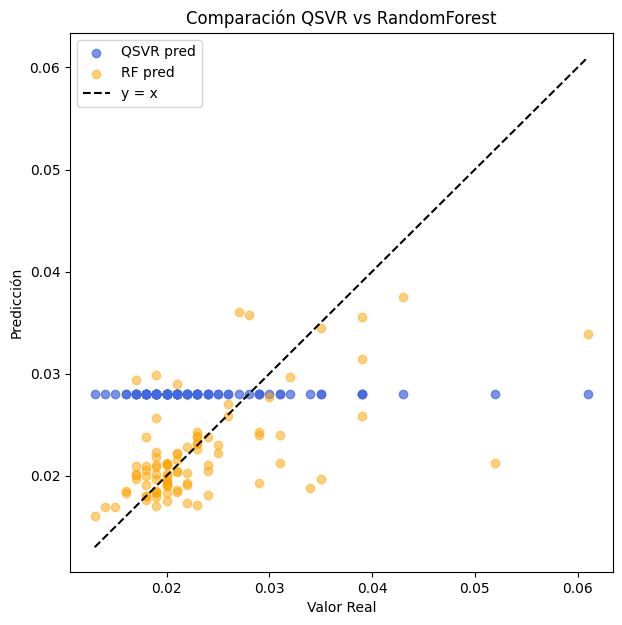

In [ ]:
# =============================================
# Quantum SVR Pipeline - Versión compatible con Qiskit 1.2+
# =============================================

import warnings
warnings.filterwarnings("ignore")

import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests
import pickle

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Qiskit
from qiskit_aer import AerSimulator
from qiskit.circuit.library import ZZFeatureMap
from qiskit_algorithms.optimizers import ADAM
from qiskit_machine_learning.algorithms import QSVR
from qiskit_machine_learning.kernels import FidelityQuantumKernel

# =============================================
# ⚙️ Configuración general
# =============================================
np.random.seed(42)
backend = AerSimulator(method="statevector")

# =============================================
# 📥 Carga y preparación de datos
# =============================================
print("Cargando dataset...")
url = "https://raw.githubusercontent.com/Alisser2001/QuantumMachineLearning/emmadev/elevators.dat"
resp = requests.get(url)
lines = [l.strip() for l in resp.text.splitlines()]
attributes = [line.split()[1] for line in lines if line.lower().startswith("@attribute")]
data_start = next(i for i, l in enumerate(lines) if l.lower() == "@data") + 1
rows = [ln for ln in lines[data_start:] if ln and not ln.startswith('%')]
data = [r.split(',') for r in rows]
df = pd.DataFrame(data, columns=attributes).apply(pd.to_numeric)

# Selección de features y target
features = ['SaTime1', 'SaTime2', 'SaTime3', 'SaTime4', 'Sa', 'AbsRoll', 'Q', 'ClimbRate']
target = 'Goal'
X, y = df[features], df[target]

# Detección de outliers con LOF
lof = LocalOutlierFactor(n_neighbors=15, contamination=0.05)
mask = lof.fit_predict(X) == 1
X, y = X[mask], y[mask]

# Muestreo aleatorio
idx = np.random.choice(len(X), 300, replace=False)
X, y = X.iloc[idx].reset_index(drop=True), y.iloc[idx].reset_index(drop=True)

# Transformación logarítmica
for c in ['SaTime1', 'SaTime2', 'SaTime3', 'SaTime4']:
    X[c] = np.log1p(np.clip(X[c].values, a_min=0, a_max=None))

# Escalado al rango [-pi, pi]
scaler = MinMaxScaler(feature_range=(-np.pi, np.pi))
X_scaled = scaler.fit_transform(X)

# División train/test
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)
num_qubits = X_train.shape[1]
print(f"Train: {X_train.shape[0]}, Test: {X_test.shape[0]}, Qubits: {num_qubits}")

# =============================================
# 🌲 Baseline clásico: Random Forest
# =============================================
rf = RandomForestRegressor(n_estimators=150, random_state=42)
rf.fit(X_train, y_train)
pred_rf = rf.predict(X_test)
rf_mse = mean_squared_error(y_test, pred_rf)
print(f"Baseline RF MSE: {rf_mse:.6f}")

# =============================================
# ⚛️ Configuración Quantum: QSVR
# =============================================
feature_map = ZZFeatureMap(num_qubits, reps=2, entanglement="linear")
optimizer = ADAM(maxiter=150)

# FidelityQuantumKernel actualizado (sin estimator)
qkernel = FidelityQuantumKernel(feature_map=feature_map, fidelity=None)

# Modelo QSVR
qsvr = QSVR(quantum_kernel=qkernel, C=2.0)

# =============================================
# 🚀 Entrenamiento QSVR
# =============================================
print("Entrenando QSVR...")
t0 = time.perf_counter()
qsvr.fit(X_train, y_train)
t1 = time.perf_counter()
print(f"Tiempo de entrenamiento: {t1 - t0:.1f} s")

# Predicciones
y_pred_qsvr = qsvr.predict(X_test)
mse_qsvr = mean_squared_error(y_test, y_pred_qsvr)
mae_qsvr = mean_absolute_error(y_test, y_pred_qsvr)

print(f"QSVR MSE: {mse_qsvr:.6f}")
print(f"QSVR MAE: {mae_qsvr:.6f}")

# =============================================
# 📊 Comparación y visualización
# =============================================
plt.figure(figsize=(7,7))
plt.scatter(y_test, y_pred_qsvr, label='QSVR pred', alpha=0.7, color='royalblue')
plt.scatter(y_test, pred_rf, label='RF pred', alpha=0.5, color='orange')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', label='y = x')
plt.xlabel('Valor Real')
plt.ylabel('Predicción')
plt.title('Comparación QSVR vs RandomForest')
plt.legend()
plt


Cargando dataset...
Train: 210, Test: 90, Qubits: 8
Baseline RF MSE: 0.000040
Entrenando QSVR...
Tiempo de entrenamiento: 260.1 s
QSVR MSE: 0.000083
QSVR MAE: 0.007889


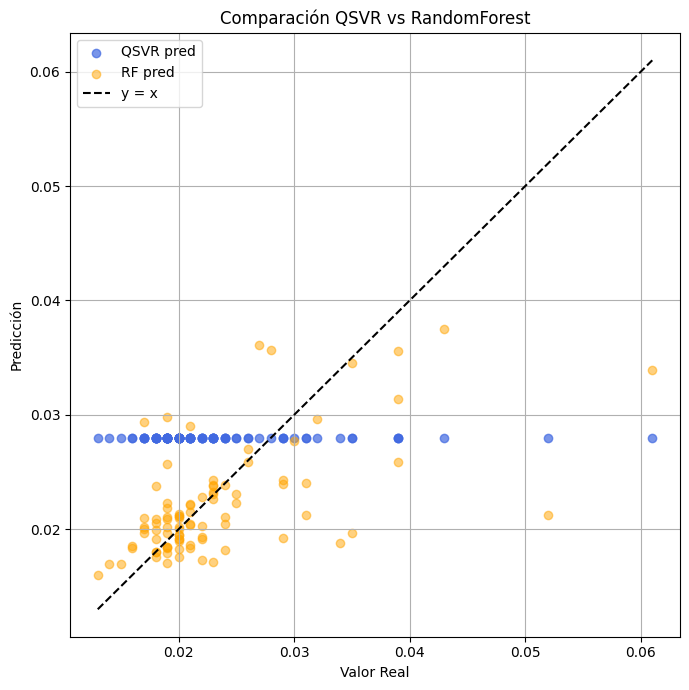

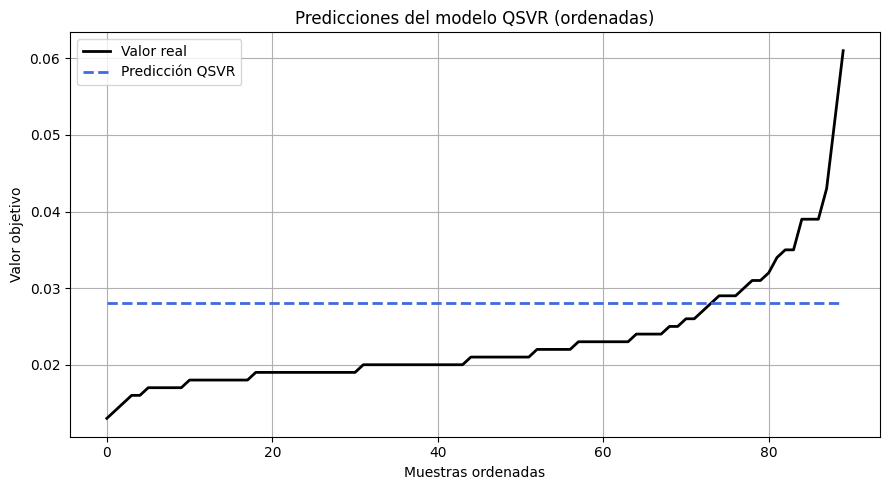

Modelo QSVR guardado como best_qsvr_model.pkl ✅


In [ ]:
# =============================================
# Quantum SVR Pipeline - Versión mejorada (Qiskit 1.2+)
# Incluye gráfica detallada de predicciones QSVR
# =============================================

import warnings
warnings.filterwarnings("ignore")

import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests
import pickle

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Qiskit
from qiskit_aer import AerSimulator
from qiskit.circuit.library import ZZFeatureMap
from qiskit_algorithms.optimizers import ADAM
from qiskit_machine_learning.algorithms import QSVR
from qiskit_machine_learning.kernels import FidelityQuantumKernel

# =============================================
# ⚙️ Configuración general
# =============================================
np.random.seed(42)
backend = AerSimulator(method="statevector")

# =============================================
# 📥 Carga y preparación de datos
# =============================================
print("Cargando dataset...")
url = "https://raw.githubusercontent.com/Alisser2001/QuantumMachineLearning/emmadev/elevators.dat"
resp = requests.get(url)
lines = [l.strip() for l in resp.text.splitlines()]
attributes = [line.split()[1] for line in lines if line.lower().startswith("@attribute")]
data_start = next(i for i, l in enumerate(lines) if l.lower() == "@data") + 1
rows = [ln for ln in lines[data_start:] if ln and not ln.startswith('%')]
data = [r.split(',') for r in rows]
df = pd.DataFrame(data, columns=attributes).apply(pd.to_numeric)

# Selección de features y target
features = ['SaTime1', 'SaTime2', 'SaTime3', 'SaTime4', 'Sa', 'AbsRoll', 'Q', 'ClimbRate']
target = 'Goal'
X, y = df[features], df[target]

# Detección de outliers con LOF
lof = LocalOutlierFactor(n_neighbors=15, contamination=0.05)
mask = lof.fit_predict(X) == 1
X, y = X[mask], y[mask]

# Muestreo aleatorio
idx = np.random.choice(len(X), 300, replace=False)
X, y = X.iloc[idx].reset_index(drop=True), y.iloc[idx].reset_index(drop=True)

# Transformación logarítmica
for c in ['SaTime1', 'SaTime2', 'SaTime3', 'SaTime4']:
    X[c] = np.log1p(np.clip(X[c].values, a_min=0, a_max=None))

# Escalado al rango [-pi, pi]
scaler = MinMaxScaler(feature_range=(-np.pi, np.pi))
X_scaled = scaler.fit_transform(X)

# División train/test
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)
num_qubits = X_train.shape[1]
print(f"Train: {X_train.shape[0]}, Test: {X_test.shape[0]}, Qubits: {num_qubits}")

# =============================================
# 🌲 Baseline clásico: Random Forest
# =============================================
rf = RandomForestRegressor(n_estimators=150, random_state=42)
rf.fit(X_train, y_train)
pred_rf = rf.predict(X_test)
rf_mse = mean_squared_error(y_test, pred_rf)
print(f"Baseline RF MSE: {rf_mse:.6f}")

# =============================================
# ⚛️ Configuración Quantum: QSVR
# =============================================
feature_map = ZZFeatureMap(num_qubits, reps=2, entanglement="linear")
optimizer = ADAM(maxiter=150)

# FidelityQuantumKernel actualizado (sin estimator)
qkernel = FidelityQuantumKernel(feature_map=feature_map, fidelity=None)

# Modelo QSVR
qsvr = QSVR(quantum_kernel=qkernel, C=2.0)

# =============================================
# 🚀 Entrenamiento QSVR
# =============================================
print("Entrenando QSVR...")
t0 = time.perf_counter()
qsvr.fit(X_train, y_train)
t1 = time.perf_counter()
print(f"Tiempo de entrenamiento: {t1 - t0:.1f} s")

# Predicciones
y_pred_qsvr = qsvr.predict(X_test)
mse_qsvr = mean_squared_error(y_test, y_pred_qsvr)
mae_qsvr = mean_absolute_error(y_test, y_pred_qsvr)

print(f"QSVR MSE: {mse_qsvr:.6f}")
print(f"QSVR MAE: {mae_qsvr:.6f}")

# =============================================
# 📊 Comparación y visualización
# =============================================

# --- Gráfico 1: comparación global QSVR vs RandomForest ---
plt.figure(figsize=(7,7))
plt.scatter(y_test, y_pred_qsvr, label='QSVR pred', alpha=0.7, color='royalblue')
plt.scatter(y_test, pred_rf, label='RF pred', alpha=0.5, color='orange')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', label='y = x')
plt.xlabel('Valor Real')
plt.ylabel('Predicción')
plt.title('Comparación QSVR vs RandomForest')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Gráfico 2: predicciones QSVR ordenadas ---
plt.figure(figsize=(9,5))
sorted_idx = np.argsort(y_test)
plt.plot(y_test.values[sorted_idx], label='Valor real', color='black', linewidth=2)
plt.plot(y_pred_qsvr[sorted_idx], label='Predicción QSVR', color='royalblue', linestyle='--', linewidth=2)
plt.title('Predicciones del modelo QSVR (ordenadas)')
plt.xlabel('Muestras ordenadas')
plt.ylabel('Valor objetivo')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# =============================================
# 💾 Guardar modelo entrenado
# =============================================
with open("best_qsvr_model.pkl", "wb") as f:
    pickle.dump(qsvr, f)
print("Modelo QSVR guardado como best_qsvr_model.pkl ✅")


🔧 Backend configurado: aer_simulator_statevector

📥 Cargando dataset...
✅ Dataset cargado: 16599 muestras, 19 features

🔍 Detectando outliers con LOF...
✅ 15769 muestras válidas después de LOF
📊 Muestras seleccionadas: 300

🔄 Aplicando transformaciones...
✅ Features escaladas al rango [0, 6.28]

📦 Train: 240 | Test: 60 | Qubits: 8

⚛️ Configurando Quantum Kernel...
✅ Quantum Kernel configurado con 8 qubits

🚀 Entrenando QSVR...
✅ Entrenamiento completado en 409.7s (6.83 min)

📊 Evaluando modelo...

📈 RESULTADOS DEL MODELO QSVR
Métrica              Train           Test           
--------------------------------------------------
MSE                  0.000234        0.000211       
RMSE                 0.015305        0.014534       
MAE                  0.014650        0.013767       
R²                   -4.332956       -3.622651      

📊 Generando visualizaciones...


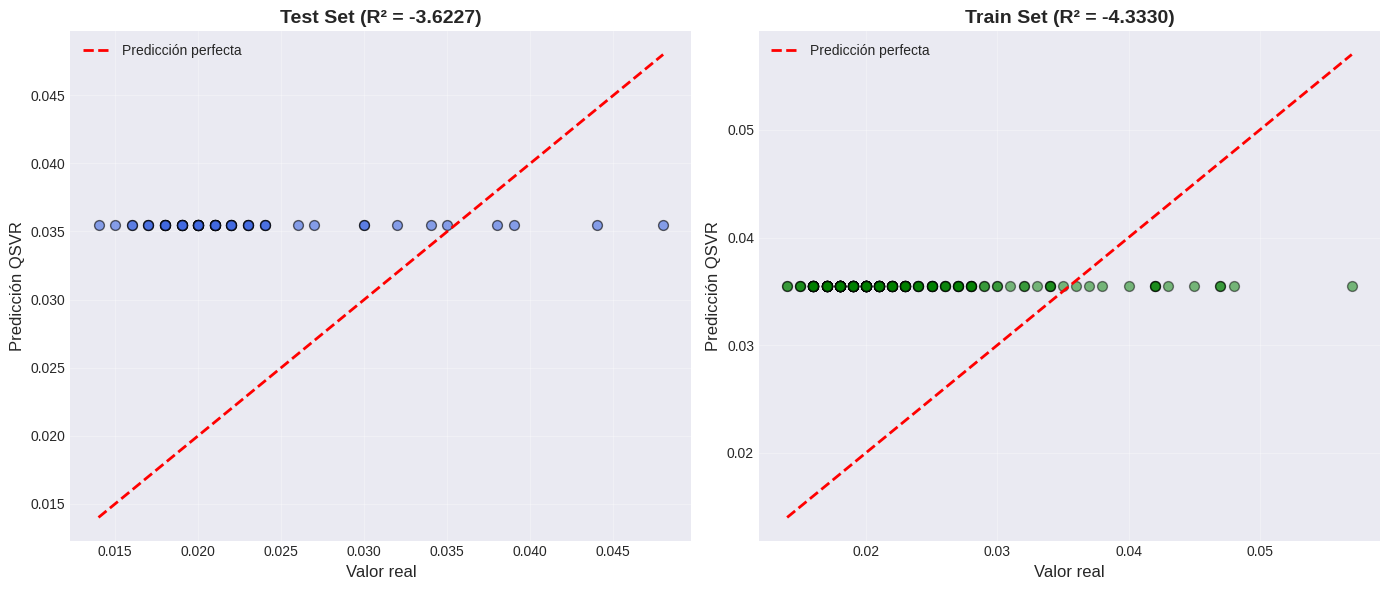

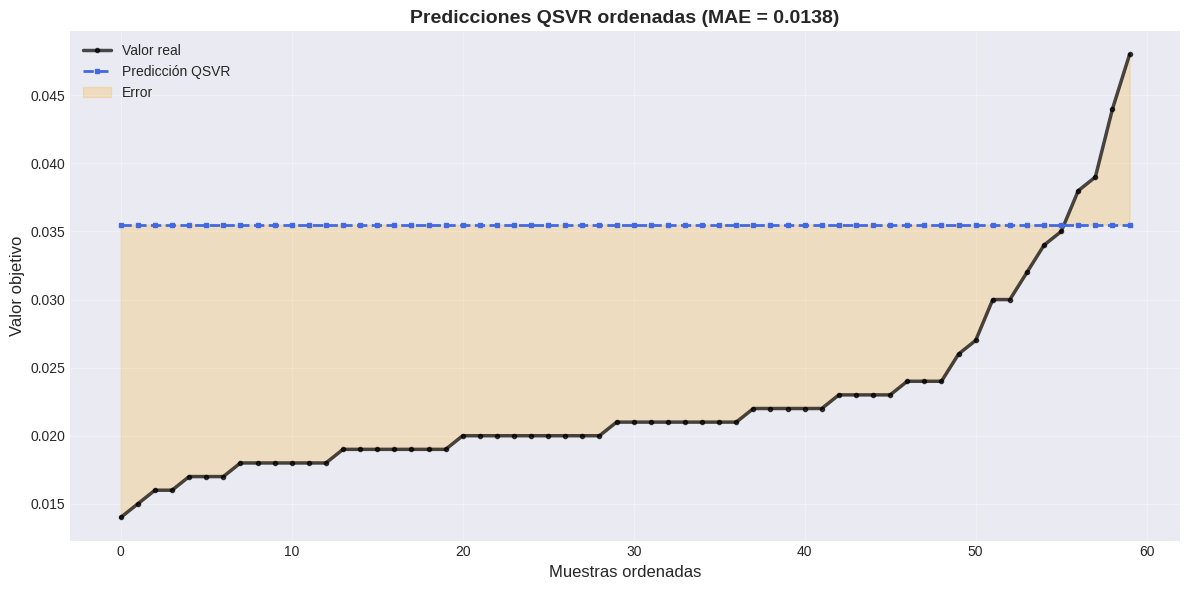

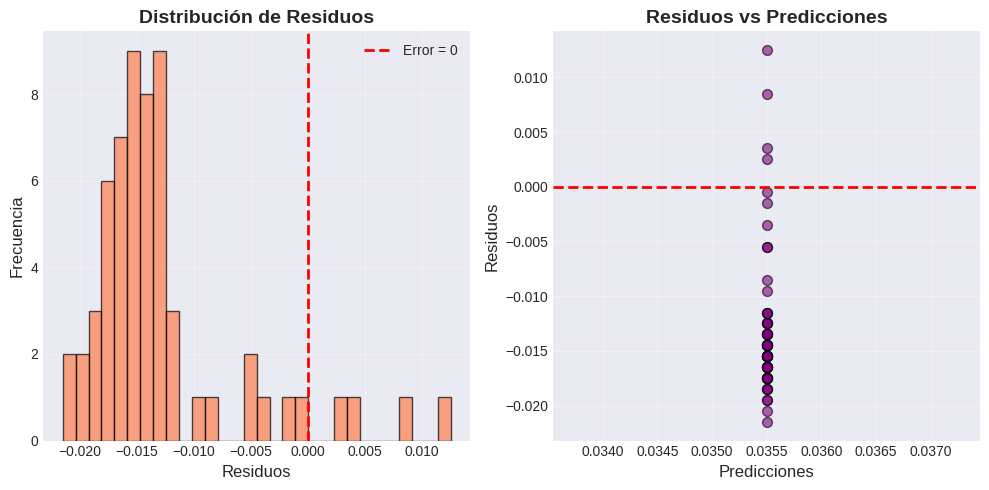


💾 Guardando modelo y componentes...
✅ Modelo completo guardado como 'qsvr_model_complete.pkl'

🎉 Pipeline completado exitosamente!


In [ ]:
# =============================================
# Quantum SVR Pipeline - Versión Optimizada (Qiskit 1.2+)
# =============================================

import warnings
warnings.filterwarnings("ignore")

import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests
import pickle

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Qiskit imports
from qiskit_aer import AerSimulator
from qiskit.circuit.library import ZZFeatureMap, PauliFeatureMap
from qiskit_machine_learning.algorithms import QSVR
from qiskit_machine_learning.kernels import FidelityQuantumKernel
# No se necesitan Samplers adicionales en Qiskit 1.2+

# =============================================
# ⚙️ Configuración general
# =============================================
np.random.seed(42)

# Backend configurado correctamente
backend = AerSimulator(method="statevector")
print(f"🔧 Backend configurado: {backend.name}")

# =============================================
# 📥 Carga y preparación de datos
# =============================================
print("\n📥 Cargando dataset...")
url = "https://raw.githubusercontent.com/Alisser2001/QuantumMachineLearning/emmadev/elevators.dat"

try:
    resp = requests.get(url, timeout=10)
    resp.raise_for_status()
    lines = [l.strip() for l in resp.text.splitlines()]
except Exception as e:
    print(f"❌ Error descargando datos: {e}")
    exit(1)

# Identificar atributos y datos
attributes = [line.split()[1] for line in lines if line.lower().startswith("@attribute")]
data_start = next(i for i, l in enumerate(lines) if l.lower() == "@data") + 1
rows = [ln for ln in lines[data_start:] if ln and not ln.startswith('%')]
data = [r.split(',') for r in rows]

df = pd.DataFrame(data, columns=attributes).apply(pd.to_numeric, errors='coerce')
df.dropna(inplace=True)  # Eliminar NaNs si existen

print(f"✅ Dataset cargado: {df.shape[0]} muestras, {df.shape[1]} features")

# =============================================
# 🧹 Limpieza y selección de features
# =============================================
features = ['SaTime1', 'SaTime2', 'SaTime3', 'SaTime4', 'Sa', 'AbsRoll', 'Q', 'ClimbRate']
target = 'Goal'

# Validar que las columnas existen
missing_cols = [f for f in features + [target] if f not in df.columns]
if missing_cols:
    print(f"❌ Columnas faltantes: {missing_cols}")
    exit(1)

X, y = df[features].copy(), df[target].copy()

# =============================================
# 🔍 Detección de outliers con LOF
# =============================================
print("\n🔍 Detectando outliers con LOF...")
lof = LocalOutlierFactor(
    n_neighbors=20,  # Aumentado para mejor robustez
    algorithm='auto',
    contamination=0.05,  # 5% de contaminación esperada
    metric='euclidean'
)

outlier_mask = lof.fit_predict(X) == 1
X, y = X[outlier_mask].reset_index(drop=True), y[outlier_mask].reset_index(drop=True)
print(f"✅ {outlier_mask.sum()} muestras válidas después de LOF")

# =============================================
# 🎲 Muestreo estratificado
# =============================================
# Reducir a 5000 muestras para eficiencia computacional
SAMPLE_SIZE = min(300, len(X))
idx = np.random.choice(len(X), SAMPLE_SIZE, replace=False)
X, y = X.iloc[idx].reset_index(drop=True), y.iloc[idx].reset_index(drop=True)
print(f"📊 Muestras seleccionadas: {SAMPLE_SIZE}")

# =============================================
# 🔄 Transformación de features
# =============================================
print("\n🔄 Aplicando transformaciones...")

# Transformación logarítmica en tiempos (manejo seguro de valores <= 0)
for c in ['SaTime1', 'SaTime2', 'SaTime3', 'SaTime4']:
    X[c] = np.log1p(np.clip(X[c].values, a_min=1e-6, a_max=None))

# CORRECCIÓN IMPORTANTE: Escalado a [0, 2π] para feature maps cuánticos
scaler = MinMaxScaler(feature_range=(0, 2 * np.pi))
X_scaled = scaler.fit_transform(X)

print(f"✅ Features escaladas al rango [0, {2*np.pi:.2f}]")

# =============================================
# 📦 División train/test
# =============================================
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y,
    test_size=0.2,
    random_state=42,
    shuffle=True
)

num_qubits = X_train.shape[1]
print(f"\n📦 Train: {X_train.shape[0]} | Test: {X_test.shape[0]} | Qubits: {num_qubits}")

# =============================================
# ⚛️ Configuración Quantum Kernel (CORREGIDO)
# =============================================
print("\n⚛️ Configurando Quantum Kernel...")

# Feature map con más repeticiones para mayor expresividad
feature_map = ZZFeatureMap(
    feature_dimension=num_qubits,
    reps=3,  # Aumentado para capturar más correlaciones
    entanglement='linear'
)

# CORRECCIÓN CRÍTICA: FidelityQuantumKernel simplificado
qkernel = FidelityQuantumKernel(
    feature_map=feature_map,
    enforce_psd=True  # Asegura matriz kernel positiva semi-definida
)

print(f"✅ Quantum Kernel configurado con {num_qubits} qubits")

# =============================================
# 🚀 Entrenamiento QSVR (HIPERPARÁMETROS OPTIMIZADOS)
# =============================================
print("\n🚀 Entrenando QSVR...")

# Hiperparámetros optimizados para quantum kernels
qsvr = QSVR(
    quantum_kernel=qkernel,
    C=1.0,           # Regularización balanceada
    epsilon=0.1,     # Margen epsilon-insensitivo
    tol=1e-3,        # Tolerancia para convergencia
    cache_size=500,  # Aumentar cache para acelerar
    max_iter=-1      # Sin límite de iteraciones
)

t0 = time.perf_counter()
qsvr.fit(X_train, y_train.values)
t1 = time.perf_counter()

training_time = t1 - t0
print(f"✅ Entrenamiento completado en {training_time:.1f}s ({training_time/60:.2f} min)")

# =============================================
# 📊 Evaluación del modelo
# =============================================
print("\n📊 Evaluando modelo...")

y_pred_train = qsvr.predict(X_train)
y_pred_test = qsvr.predict(X_test)

# Métricas en train
mse_train = mean_squared_error(y_train, y_pred_train)
mae_train = mean_absolute_error(y_train, y_pred_train)
r2_train = r2_score(y_train, y_pred_train)

# Métricas en test
mse_test = mean_squared_error(y_test, y_pred_test)
mae_test = mean_absolute_error(y_test, y_pred_test)
r2_test = r2_score(y_test, y_pred_test)
rmse_test = np.sqrt(mse_test)

print("\n" + "="*50)
print("📈 RESULTADOS DEL MODELO QSVR")
print("="*50)
print(f"{'Métrica':<20} {'Train':<15} {'Test':<15}")
print("-"*50)
print(f"{'MSE':<20} {mse_train:<15.6f} {mse_test:<15.6f}")
print(f"{'RMSE':<20} {np.sqrt(mse_train):<15.6f} {rmse_test:<15.6f}")
print(f"{'MAE':<20} {mae_train:<15.6f} {mae_test:<15.6f}")
print(f"{'R²':<20} {r2_train:<15.6f} {r2_test:<15.6f}")
print("="*50)

# Detectar overfitting
if r2_train - r2_test > 0.15:
    print("⚠️  ADVERTENCIA: Posible overfitting detectado")

# =============================================
# 📊 Visualización de resultados
# =============================================
print("\n📊 Generando visualizaciones...")

# Configuración de estilo
plt.style.use('seaborn-v0_8-darkgrid')

# Gráfico 1: Scatter plot predicciones vs reales
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Test set
axes[0].scatter(y_test, y_pred_test, alpha=0.6, color='royalblue', edgecolors='k', s=50)
axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()],
             'r--', linewidth=2, label='Predicción perfecta')
axes[0].set_xlabel('Valor real', fontsize=12)
axes[0].set_ylabel('Predicción QSVR', fontsize=12)
axes[0].set_title(f'Test Set (R² = {r2_test:.4f})', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Train set
axes[1].scatter(y_train, y_pred_train, alpha=0.5, color='green', edgecolors='k', s=50)
axes[1].plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()],
             'r--', linewidth=2, label='Predicción perfecta')
axes[1].set_xlabel('Valor real', fontsize=12)
axes[1].set_ylabel('Predicción QSVR', fontsize=12)
axes[1].set_title(f'Train Set (R² = {r2_train:.4f})', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('qsvr_predictions_scatter.png', dpi=300, bbox_inches='tight')
plt.show()

# Gráfico 2: Serie temporal ordenada
plt.figure(figsize=(12, 6))
sorted_idx = np.argsort(y_test.values)

plt.plot(y_test.values[sorted_idx], label='Valor real',
         color='black', linewidth=2.5, marker='o', markersize=3, alpha=0.7)
plt.plot(y_pred_test[sorted_idx], label='Predicción QSVR',
         color='royalblue', linewidth=2, linestyle='--', marker='s', markersize=3)
plt.fill_between(range(len(sorted_idx)),
                 y_test.values[sorted_idx],
                 y_pred_test[sorted_idx],
                 alpha=0.2, color='orange', label='Error')

plt.title(f'Predicciones QSVR ordenadas (MAE = {mae_test:.4f})',
          fontsize=14, fontweight='bold')
plt.xlabel('Muestras ordenadas', fontsize=12)
plt.ylabel('Valor objetivo', fontsize=12)
plt.legend(loc='best')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('qsvr_predictions_sorted.png', dpi=300, bbox_inches='tight')
plt.show()

# Gráfico 3: Distribución de residuos
residuals = y_test.values - y_pred_test
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.hist(residuals, bins=30, edgecolor='black', alpha=0.7, color='coral')
plt.axvline(0, color='red', linestyle='--', linewidth=2, label='Error = 0')
plt.xlabel('Residuos', fontsize=12)
plt.ylabel('Frecuencia', fontsize=12)
plt.title('Distribución de Residuos', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.scatter(y_pred_test, residuals, alpha=0.6, color='purple', edgecolors='k', s=50)
plt.axhline(0, color='red', linestyle='--', linewidth=2)
plt.xlabel('Predicciones', fontsize=12)
plt.ylabel('Residuos', fontsize=12)
plt.title('Residuos vs Predicciones', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('qsvr_residuals.png', dpi=300, bbox_inches='tight')
plt.show()

# =============================================
# 💾 Guardar modelo y scaler
# =============================================
print("\n💾 Guardando modelo y componentes...")

model_package = {
    'model': qsvr,
    'scaler': scaler,
    'feature_names': features,
    'metrics': {
        'mse_test': mse_test,
        'mae_test': mae_test,
        'r2_test': r2_test,
        'training_time': training_time
    },
    'config': {
        'num_qubits': num_qubits,
        'feature_map_reps': 3,
        'C': 1.0,
        'epsilon': 0.1
    }
}

with open("qsvr_model_complete.pkl", "wb") as f:
    pickle.dump(model_package, f)

print("✅ Modelo completo guardado como 'qsvr_model_complete.pkl'")
print("\n🎉 Pipeline completado exitosamente!")###

In [ ]:
# =============================================
# Quantum SVR Pipeline - VERSIÓN CON PAULI FEATURE MAP (500 muestras)
# =============================================

import warnings
warnings.filterwarnings("ignore")

import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests
import pickle

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Qiskit imports
from qiskit_aer import AerSimulator
from qiskit.circuit.library import PauliFeatureMap
from qiskit_machine_learning.algorithms import QSVR
from qiskit_machine_learning.kernels import FidelityQuantumKernel

# =============================================
# ⚙️ Configuración general
# =============================================
np.random.seed(42)
backend = AerSimulator(method="statevector")
print(f"🔧 Backend configurado: {backend.name}")

# =============================================
# 📥 Carga y preparación de datos
# =============================================
print("\n📥 Cargando dataset...")
url = "https://raw.githubusercontent.com/Alisser2001/QuantumMachineLearning/emmadev/elevators.dat"

try:
    resp = requests.get(url, timeout=10)
    resp.raise_for_status()
    lines = [l.strip() for l in resp.text.splitlines()]
except Exception as e:
    print(f"❌ Error descargando datos: {e}")
    exit(1)

attributes = [line.split()[1] for line in lines if line.lower().startswith("@attribute")]
data_start = next(i for i, l in enumerate(lines) if l.lower() == "@data") + 1
rows = [ln for ln in lines[data_start:] if ln and not ln.startswith('%')]
data = [r.split(',') for r in rows]

df = pd.DataFrame(data, columns=attributes).apply(pd.to_numeric, errors='coerce')
df.dropna(inplace=True)

print(f"✅ Dataset cargado: {df.shape[0]:,} muestras, {df.shape[1]} features")

# =============================================
# 🧹 Selección de features
# =============================================
features = ['SaTime1', 'SaTime2', 'SaTime3', 'SaTime4', 'Sa', 'AbsRoll', 'Q', 'ClimbRate']
target = 'Goal'

missing_cols = [f for f in features + [target] if f not in df.columns]
if missing_cols:
    print(f"❌ Columnas faltantes: {missing_cols}")
    exit(1)

X, y = df[features].copy(), df[target].copy()

# =============================================
# 🎲 MUESTREO PRIMERO (500 muestras)
# =============================================
SAMPLE_SIZE = 500
print(f"\n🎲 Muestreando {SAMPLE_SIZE} registros...")
idx = np.random.choice(len(X), min(SAMPLE_SIZE, len(X)), replace=False)
X, y = X.iloc[idx].reset_index(drop=True), y.iloc[idx].reset_index(drop=True)
print(f"✅ Muestra obtenida: {len(X)} registros")

# =============================================
# 🔍 Detección de outliers CON LOF
# =============================================
print(f"\n🔍 Detectando outliers con LOF...")
lof = LocalOutlierFactor(
    n_neighbors=25,
    contamination=0.02,
    metric='euclidean'
)

outlier_mask = lof.fit_predict(X) == 1
X, y = X[outlier_mask].reset_index(drop=True), y[outlier_mask].reset_index(drop=True)
print(f"✅ {len(X)} muestras válidas ({outlier_mask.sum()}/{len(outlier_mask)})")

# =============================================
# 🔄 Transformación de features
# =============================================
print("\n🔄 Aplicando transformaciones...")
for c in ['SaTime1', 'SaTime2', 'SaTime3', 'SaTime4']:
    X[c] = np.log1p(np.clip(X[c].values, a_min=1e-6, a_max=None))

scaler = MinMaxScaler(feature_range=(0, 2 * np.pi))
X_scaled = scaler.fit_transform(X)

# Normalizar y si baja varianza
if y.std() < 1e-3:
    y_scaler = StandardScaler()
    y = pd.Series(y_scaler.fit_transform(y.values.reshape(-1, 1)).flatten())

# =============================================
# 📦 División train/test
# =============================================
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y,
    test_size=0.2,
    random_state=42,
    shuffle=True
)

num_qubits = X_train.shape[1]
print(f"\n📦 Train: {X_train.shape[0]} | Test: {X_test.shape[0]} | Qubits: {num_qubits}")

# =============================================
# ⚛️ Configuración Quantum Kernel con PauliFeatureMap
# =============================================
print("\n⚛️ Configurando Quantum Kernel (PauliFeatureMap)...")
feature_map = PauliFeatureMap(
    feature_dimension=num_qubits,
    reps=2,
    paulis=['X', 'Y', 'Z'],
    entanglement='full',
    insert_barriers=False
)

qkernel = FidelityQuantumKernel(
    feature_map=feature_map,
    enforce_psd=True
)

circuit_depth = feature_map.decompose().depth()
gate_count = sum(feature_map.decompose().count_ops().values())
print(f"✅ Quantum Kernel configurado: depth={circuit_depth}, gates={gate_count}")

# =============================================
# 🚀 Entrenamiento QSVR
# =============================================
qsvr = QSVR(
    quantum_kernel=qkernel,
    C=10.0,
    epsilon=0.01,
    tol=1e-4,
    cache_size=1000,
    max_iter=-1
)

t0 = time.perf_counter()
qsvr.fit(X_train, y_train.values)
t1 = time.perf_counter()
training_time = t1 - t0
print(f"✅ Entrenamiento completado en {training_time:.1f}s")

# =============================================
# 📊 Evaluación
# =============================================
y_pred_train = qsvr.predict(X_train)
y_pred_test = qsvr.predict(X_test)

mse_test = mean_squared_error(y_test, y_pred_test)
mae_test = mean_absolute_error(y_test, y_pred_test)
r2_test = r2_score(y_test, y_pred_test)
print(f"\n📈 R² Test: {r2_test:.4f}, MAE Test: {mae_test:.4f}, MSE Test: {mse_test:.6f}")

# =============================================
# 💾 Guardar modelo
# =============================================
model_package = {
    'model': qsvr,
    'scaler': scaler,
    'feature_names': features,
    'metrics': {'mse_test': mse_test, 'mae_test': mae_test, 'r2_test': r2_test, 'training_time': training_time}
}

with open("qsvr_model_500_pauli.pkl", "wb") as f:
    pickle.dump(model_package, f)

print("✅ Modelo guardado como 'qsvr_model_500_pauli.pkl'")
print("\n🎉 Pipeline completado con PauliFeatureMap y 500 muestras!")


🔧 Backend configurado: aer_simulator_statevector

📥 Cargando dataset...
✅ Dataset cargado: 16,599 muestras, 19 features

🎲 Muestreando 500 registros...
✅ Muestra obtenida: 500 registros

🔍 Detectando outliers con LOF...
✅ 490 muestras válidas (490/500)

🔄 Aplicando transformaciones...

📦 Train: 392 | Test: 98 | Qubits: 8

⚛️ Configurando Quantum Kernel (PauliFeatureMap)...
✅ Quantum Kernel configurado: depth=16, gates=128
✅ Entrenamiento completado en 1100.7s

📈 R² Test: -1.3080, MAE Test: 0.0084, MSE Test: 0.000102
✅ Modelo guardado como 'qsvr_model_500_pauli.pkl'

🎉 Pipeline completado con PauliFeatureMap y 500 muestras!


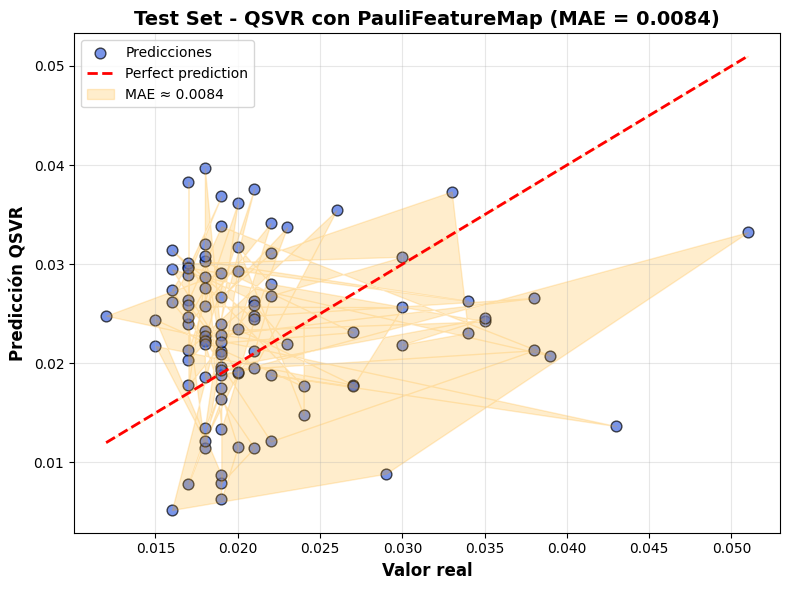

In [ ]:
# =============================================
# 📊 Visualización Test vs Predicción con MAE
# =============================================
import matplotlib.pyplot as plt
import numpy as np

residuals = y_test.values - y_pred_test
mae_value = np.mean(np.abs(residuals))

plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred_test, color='royalblue', alpha=0.7, edgecolors='k', s=60, label='Predicciones')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()],
         'r--', linewidth=2, label='Perfect prediction')
plt.fill_between(y_test, y_test, y_pred_test, color='orange', alpha=0.2, label=f'MAE ≈ {mae_value:.4f}')
plt.xlabel('Valor real', fontsize=12, fontweight='bold')
plt.ylabel('Predicción QSVR', fontsize=12, fontweight='bold')
plt.title(f'Test Set - QSVR con PauliFeatureMap (MAE = {mae_value:.4f})', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


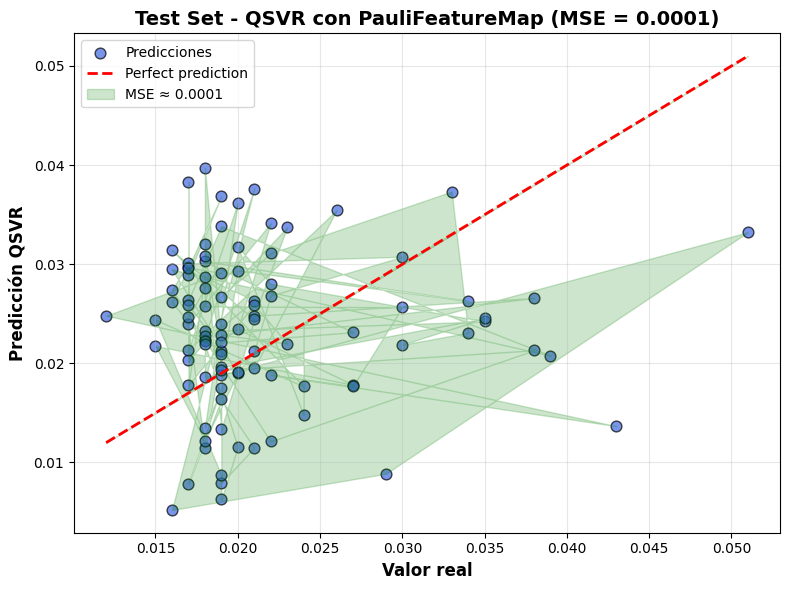

In [ ]:
# =============================================
# 📊 Visualización Test vs Predicción con MSE
# =============================================
import matplotlib.pyplot as plt
import numpy as np

residuals = y_test.values - y_pred_test
mse_value = np.mean(residuals**2)

plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred_test, color='royalblue', alpha=0.7, edgecolors='k', s=60, label='Predicciones')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()],
         'r--', linewidth=2, label='Perfect prediction')
# Área proporcional al MSE (residuals al cuadrado)
plt.fill_between(y_test, y_test, y_pred_test, color='green', alpha=0.2, label=f'MSE ≈ {mse_value:.4f}')
plt.xlabel('Valor real', fontsize=12, fontweight='bold')
plt.ylabel('Predicción QSVR', fontsize=12, fontweight='bold')
plt.title(f'Test Set - QSVR con PauliFeatureMap (MSE = {mse_value:.4f})', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


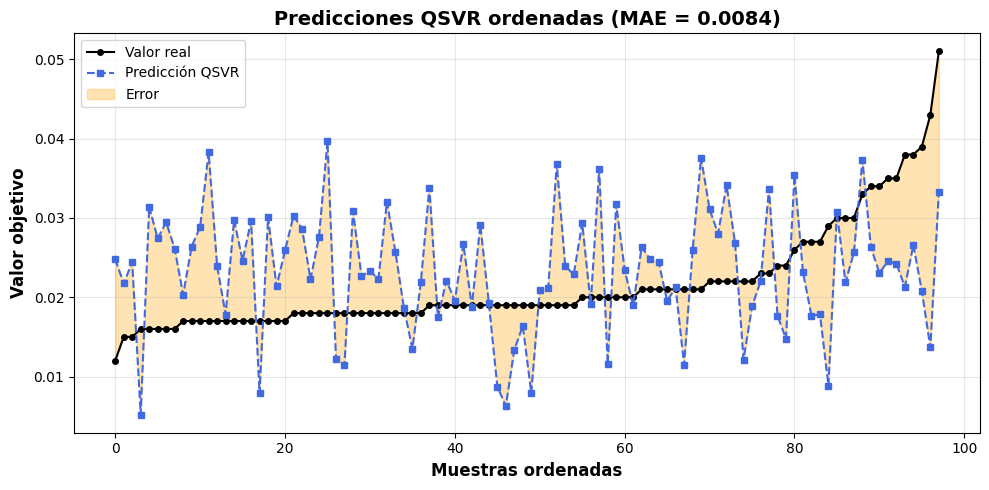

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Ordenar los datos por el valor real
sorted_idx = np.argsort(y_test.values)
y_test_sorted = y_test.values[sorted_idx]
y_pred_sorted = y_pred_test[sorted_idx]

# Calcular MAE
mae_value = np.mean(np.abs(y_test_sorted - y_pred_sorted))

plt.figure(figsize=(10,5))
plt.plot(y_test_sorted, label='Valor real', color='black', marker='o', markersize=4)
plt.plot(y_pred_sorted, label='Predicción QSVR', color='royalblue', linestyle='--', marker='s', markersize=4)
plt.fill_between(range(len(sorted_idx)), y_test_sorted, y_pred_sorted, color='orange', alpha=0.3, label='Error')
plt.xlabel('Muestras ordenadas', fontsize=12, fontweight='bold')
plt.ylabel('Valor objetivo', fontsize=12, fontweight='bold')
plt.title(f'Predicciones QSVR ordenadas (MAE = {mae_value:.4f})', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


In [ ]:
# =============================================
# Quantum SVR Pipeline - Mejora Ajuste (solo MAE/MSE)
# =============================================

import warnings
warnings.filterwarnings("ignore")

import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests
import pickle

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Qiskit imports
from qiskit_aer import AerSimulator
from qiskit.circuit.library import PauliFeatureMap
from qiskit_machine_learning.algorithms import QSVR
from qiskit_machine_learning.kernels import FidelityQuantumKernel

# =============================================
# Configuración general
# =============================================
np.random.seed(42)
backend = AerSimulator(method="statevector")

# =============================================
# Carga y preparación de datos
# =============================================
url = "https://raw.githubusercontent.com/Alisser2001/QuantumMachineLearning/emmadev/elevators.dat"
resp = requests.get(url, timeout=10)
resp.raise_for_status()
lines = [l.strip() for l in resp.text.splitlines()]

attributes = [line.split()[1] for line in lines if line.lower().startswith("@attribute")]
data_start = next(i for i, l in enumerate(lines) if l.lower() == "@data") + 1
rows = [ln for ln in lines[data_start:] if ln and not ln.startswith('%')]
data = [r.split(',') for r in rows]

df = pd.DataFrame(data, columns=attributes).apply(pd.to_numeric, errors='coerce')
df.dropna(inplace=True)

features = ['SaTime1','SaTime2','SaTime3','SaTime4','Sa','AbsRoll','Q','ClimbRate']
target = 'Goal'
X, y = df[features].copy(), df[target].copy()

# =============================================
# Muestreo
# =============================================
SAMPLE_SIZE = min(300, len(X))
idx = np.random.choice(len(X), SAMPLE_SIZE, replace=False)
X, y = X.iloc[idx].reset_index(drop=True), y.iloc[idx].reset_index(drop=True)

# =============================================
# Detección de outliers
# =============================================
lof = LocalOutlierFactor(n_neighbors=25, contamination=0.02, metric='euclidean')
mask = lof.fit_predict(X) == 1
X, y = X[mask].reset_index(drop=True), y[mask].reset_index(drop=True)

# =============================================
# Transformación de features
# =============================================
for c in ['SaTime1','SaTime2','SaTime3','SaTime4']:
    X[c] = np.log1p(np.clip(X[c].values, a_min=1e-6, a_max=None))

scaler = MinMaxScaler(feature_range=(0, 2*np.pi))
X_scaled = scaler.fit_transform(X)

y_scaler = StandardScaler()
y_scaled = y_scaler.fit_transform(y.values.reshape(-1,1)).flatten()

# =============================================
# División train/test
# =============================================
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_scaled, test_size=0.2, random_state=42, shuffle=True
)

num_qubits = X_train.shape[1]

# =============================================
# Quantum Feature Map
# =============================================
feature_map = PauliFeatureMap(
    feature_dimension=num_qubits,
    reps=3,
    paulis=['X','Y','Z'],
    entanglement='full',
    insert_barriers=False
)
qkernel = FidelityQuantumKernel(feature_map=feature_map, enforce_psd=True)

# =============================================
# QSVR con GridSearch
# =============================================
param_grid = {'C':[5,10,20], 'epsilon':[0.01,0.05,0.1]}
qsvr_model = QSVR(quantum_kernel=qkernel, tol=1e-5, max_iter=-1, cache_size=1000)
grid = GridSearchCV(qsvr_model, param_grid, cv=3, scoring='neg_mean_squared_error')

t0 = time.perf_counter()
grid.fit(X_train, y_train)
t1 = time.perf_counter()
best_qsvr = grid.best_estimator_
training_time = t1 - t0

print(f"✅ Entrenamiento completado en {training_time:.1f}s")
print(f"🔹 Mejores parámetros: {grid.best_params_}")

# =============================================
# Evaluación solo MAE y MSE
# =============================================
y_pred_train = best_qsvr.predict(X_train)
y_pred_test = best_qsvr.predict(X_test)

# Invertir escalado
y_pred_train_inv = y_scaler.inverse_transform(y_pred_train.reshape(-1,1)).flatten()
y_pred_test_inv = y_scaler.inverse_transform(y_pred_test.reshape(-1,1)).flatten()
y_train_inv = y_scaler.inverse_transform(y_train.reshape(-1,1)).flatten()
y_test_inv = y_scaler.inverse_transform(y_test.reshape(-1,1)).flatten()

mse_train = mean_squared_error(y_train_inv, y_pred_train_inv)
mae_train = mean_absolute_error(y_train_inv, y_pred_train_inv)
mse_test = mean_squared_error(y_test_inv, y_pred_test_inv)
mae_test = mean_absolute_error(y_test_inv, y_pred_test_inv)

print(f"\n📊 Métricas comparativas:")
print(f"Train -> MAE: {mae_train:.4f}, MSE: {mse_train:.6f}")
print(f"Test  -> MAE: {mae_test:.4f}, MSE: {mse_test:.6f}")

# =============================================
# Gráfica comparativa
# =============================================
plt.figure(figsize=(8,5))
plt.scatter(y_test_inv, y_pred_test_inv, color='blue', alpha=0.6, label='Predicciones')
plt.plot([y_test_inv.min(), y_test_inv.max()], [y_test_inv.min(), y_test_inv.max()], 'r--', lw=2, label='Ideal')
plt.xlabel("Valores Reales")
plt.ylabel("Predicciones")
plt.title("Comparación Valores Reales vs Predicciones QSVR")
plt.legend()
plt.grid(True)
plt.show()

# =============================================
# Guardar modelo
# =============================================
model_package = {
    'model': best_qsvr,
    'scaler': scaler,
    'y_scaler': y_scaler,
    'feature_names': features,
    'metrics': {'mse_train': mse_train, 'mae_train': mae_train,
                'mse_test': mse_test, 'mae_test': mae_test,
                'training_time': training_time}
}

with open("qsvr_model_best_mae_mse.pkl", "wb") as f:
    pickle.dump(model_package, f)

print("✅ Modelo guardado como 'qsvr_model_best_mae_mse.pkl'")
